## Import Libraries

In [1]:
# import various libaries to be used
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import skimage
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.ndimage.measurements import label

import numpy as np
import cv2
import glob
import time
import pickle

from moviepy.editor import VideoFileClip

## Support Functions

In [2]:
# function for adding heat to image
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# function for adding a threshold to the image
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# function for drawing boxes onto the final image
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# function used to get the hog features for an image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
						    pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient,
				   pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec)
        return features

# the most important function! the one that finds the cars
def find_cars2(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block):
    
    # array of rectangles where cars were detected
    rectangles = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    # define area of image to search
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   

    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 

    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 

    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict([hog_features])
            
            # implement sliding window
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                draw_img = cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

    return draw_img, rectangles


## Primary Functions

In [3]:
# function that processes images
# note that I added multiple sets of rectangles to the image prior to applying heat.
# if only a single rectangle was used, heat image was not finding all of the cars
def process_images(image_in):
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    spatial_size = (32, 32)
    hist_bins = 32
    colorspace = 'YUV'
    hog_channel = 'ALL'

    rectangles_all = []

    ystart = 380
    ystop = 656
    scale = 1.5
    out_img, rectangles = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles)
    
    ystart = 380
    ystop = 464
    scale = 1.0
    image_ret, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x)

    ystart = 380
    ystop = 496
    scale = 1.5
    image_ret, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x)

    ystart = 380
    ystop = 528
    scale = 2.0
    image_ret, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x)
    
    ystart = 416
    ystop = 480
    scale = 1.0
    image_ret, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x) 
    
    # add new
    ystart = 416
    ystop = 480
    scale = 1.0
    out_image_in, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x)

    ystart = 432
    ystop = 528
    scale = 1.5
    out_image_in, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x)

    ystart = 432
    ystop = 560
    scale = 2.0
    out_image_in, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x)

    ystart = 400
    ystop = 596
    scale = 1.5
    out_image_in, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x)
    
    ystart = 464
    ystop = 660
    scale = 1.5
    out_image_in, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x)   

    # flatten the list
    rectangles_new = [item for sublist in rectangles_all for item in sublist] 
    return rectangles_new

# function to process the video
# the difference between this function and the one for processing images
# is that we return the final image in the function
def process_images_video(image_in):
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    spatial_size = (32, 32)
    hist_bins = 32
    colorspace = 'YUV'
    hog_channel = 'ALL'

    rectangles_all = []

    ystart = 380
    ystop = 656
    scale = 1.5
    out_img, rectangles = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles)
    
    ystart = 380
    ystop = 464
    scale = 1.0
    image_ret, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x)

    ystart = 380
    ystop = 496
    scale = 1.5
    image_ret, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x)

    ystart = 380
    ystop = 528
    scale = 2.0
    image_ret, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x)
    
    ystart = 416
    ystop = 480
    scale = 1.0
    image_ret, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x) 
    
    # add new
    ystart = 416
    ystop = 480
    scale = 1.0
    out_image_in, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x)

    ystart = 432
    ystop = 528
    scale = 1.5
    out_image_in, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x)

    ystart = 432
    ystop = 560
    scale = 2.0
    out_image_in, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x)

    ystart = 400
    ystop = 596
    scale = 1.5
    out_image_in, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x)
    
    ystart = 464
    ystop = 660
    scale = 1.5
    out_image_in, rectangles_x = find_cars2(image_in, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    rectangles_all.append(rectangles_x)      
    


    # complete all image processing here so that video can be built from this function
    # flatten list
    rectangles_new = [item for sublist in rectangles_all for item in sublist]     
    # apply heat
    heat_image = np.zeros_like(image_in[:,:,0])
    heat_image = add_heat(heat_image, rectangles_new)   
    # apply threshold
    heat_image = apply_threshold(heat_image, 2)    
    # create labels used to add boxes
    labels = label(heat_image)    
    y_image = draw_labeled_bboxes(np.copy(image_in), labels)     
    
    return y_image


## Visualize Random Data

Total sample size of cars  8792  and not cars  17936
With shape of  (64, 64, 3)


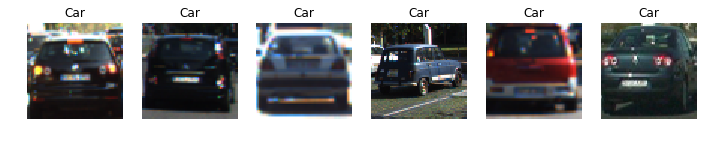

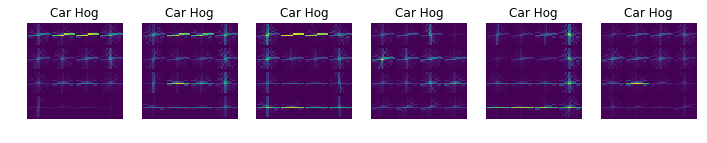

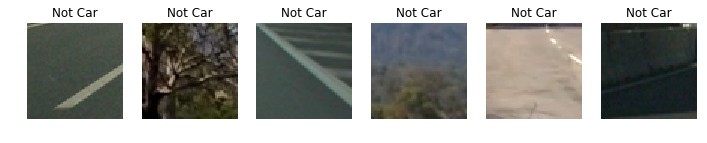

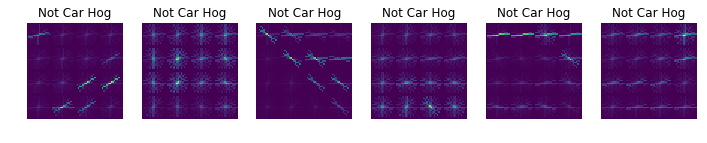

In [4]:
# grab all of the sample image data
images = glob.glob('vehicles/**/*.png')
images2 = glob.glob('non-vehicles/**/*.png')

cars = []
notcars = []

# create array of images for cars
for image in images:
    cars.append(image)
    
# create array of images for not-cars    
for image in images2:
    notcars.append(image)
    
# sampling is used to speed up processing while testing
# need to remove this for final project to ensure quality
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

# print basic info about samples
print('Total sample size of cars ', len(cars), ' and not cars ', len(notcars))
car_sample = mpimg.imread(cars[1])
print('With shape of ', car_sample.shape)

#initialize variables for getting hog features
orient = 11
pix_per_cell = 16
cell_per_block = 2
j = 0
random_car = []

# prepare axis
figure, axis = plt.subplots(1,6, figsize=(12, 12))
axis = axis.ravel()

# display sample of 6 car images
for x in range(6):
    # select random car image
    car_ind = np.random.randint(0, len(cars))

    # add the random number in a list so that we can use same image for hog display
    random_car.append(car_ind)

    # Read in car images
    car_image = mpimg.imread(cars[car_ind])

    # display cars
    axis[j].axis('off')
    car_image = car_image.squeeze()
    axis[j].set_title('Car')
    axis[j].imshow(car_image)

    j += 1

j = 0

# prepare axis
figure, axis = plt.subplots(1,6, figsize=(12, 12))
axis = axis.ravel()

# display sample of 6 hog car images
for x in range(6):
    # use same car image from list above
    car_ind = random_car[j]

    # read in car images
    car_image = mpimg.imread(cars[car_ind])

    # apply hog
    car_image = mpimg.imread(cars[car_ind])
    _, car_hog = get_hog_features(car_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

    # display hog images
    axis[j].axis('off')
    car_hog = car_hog.squeeze()
    axis[j].set_title('Car Hog')
    axis[j].imshow(car_hog)

    j += 1
    
j = 0
random_notcar = []

# prepare axis
figure, axis = plt.subplots(1,6, figsize=(12, 12))
axis = axis.ravel()

# display sample of 6 not-car images
for x in range(6):

    notcar_ind = np.random.randint(0, len(notcars))

    # add the image name to a list so we can use same image for not-car hog image below
    random_notcar.append(notcar_ind)
    
    # read in not-car images
    notcar_image = mpimg.imread(notcars[notcar_ind])

    # display hog car images
    axis[j].axis('off')
    notcar_image = notcar_image.squeeze()
    axis[j].set_title('Not Car')
    axis[j].imshow(notcar_image)

    j += 1

j = 0

# Prepare axis
figure, axis = plt.subplots(1,6, figsize=(12, 12))
axis = axis.ravel()
for x in range(6):
    notcar_ind = random_notcar[j]

    # Read in car / not-car images
    notcar_image = mpimg.imread(notcars[notcar_ind])

    notcar_image = mpimg.imread(notcars[notcar_ind])
    _, notcar_hog = get_hog_features(notcar_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

    axis[j].axis('off')
    notcar_hog = notcar_hog.squeeze()
    axis[j].set_title('Not Car Hog')
    axis[j].imshow(notcar_hog)

    j += 1
    


## Train the Classifier

In [5]:
# sampling is used to speed up processing while testing
# need to remove this for final project to ensure quality
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()

features_xx = []
for car in cars:
    new_car = mpimg.imread(car)
    # apply cvtColor
    feature_image = cv2.cvtColor(new_car, cv2.COLOR_RGB2LUV)
    hog_features_cars = []
    for channel in range(feature_image.shape[2]):
        # get hog features and append to array
        hog_features_cars.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=False))
        
    hog_features_cars = np.ravel(hog_features_cars)
    features_xx.append(hog_features_cars)
    
features_yy = []
for car in notcars:
    new_car = mpimg.imread(car)
    # apply cvtColor
    feature_image = cv2.cvtColor(new_car, cv2.COLOR_RGB2LUV)
    hog_features_notcars = []
    for channel in range(feature_image.shape[2]):
        # get hog features and append to array
        hog_features_notcars.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=False))
    hog_features_notcars = np.ravel(hog_features_notcars)
    features_yy.append(hog_features_notcars)  

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((features_xx, features_yy)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(features_xx)), np.zeros(len(features_yy))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# peinr basic training info
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10

print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

346.94 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
9.45 Seconds to train SVC...
Test Accuracy of SVC =  0.98
My SVC predicts:  [1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
For these 10 labels:  [1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
0.0998 Seconds to predict 10 labels with SVC


## Process Images

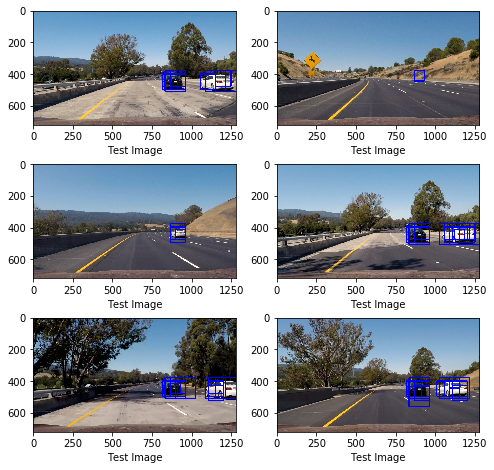

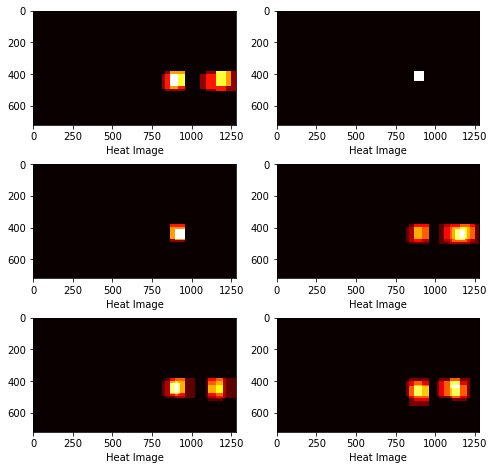

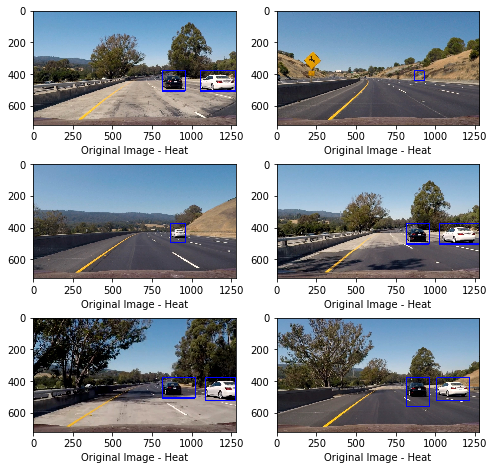

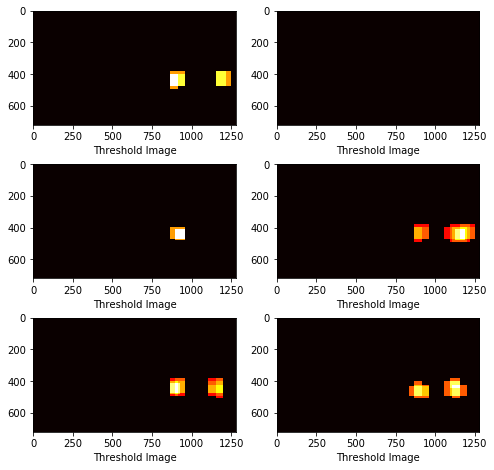

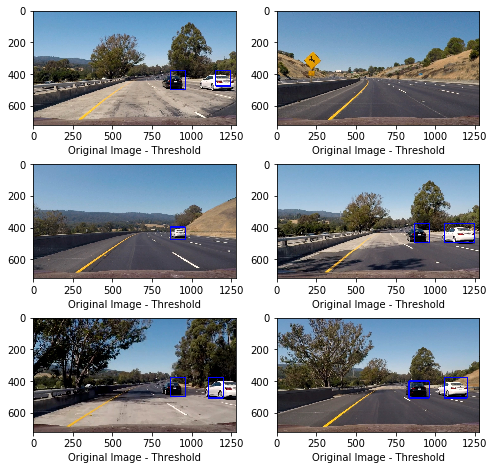

In [6]:
# draw boxes function
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# process the sample images
# first send the image through process_images function to find rectangles
# next, apply heat to image to eliminate false detections
# then apply thresholding to further eliminate false detections
# finally draw lines on the original image using image that has had heat/threshold applied
fig1, axs1 = plt.subplots(3, 2, figsize=(8,8))
axs1 = axs1.ravel()
fig2, axs2 = plt.subplots(3, 2, figsize=(8,8))
axs2 = axs2.ravel()
fig3, axs3 = plt.subplots(3, 2, figsize=(8,8))
axs3 = axs3.ravel()
fig4, axs4 = plt.subplots(3, 2, figsize=(8,8))
axs4 = axs4.ravel()
fig5, axs5 = plt.subplots(3, 2, figsize=(8,8))
axs5 = axs5.ravel()

# read in test images
test_images = glob.glob('test_images/test*.jpg')

for i, im in enumerate(test_images):
    ind_image = mpimg.imread(im)

    # create rectanges
    rectangles_proc = process_images(ind_image)
    
    #display original image with multiple rectangles
    test_image = draw_boxes(np.copy(ind_image), rectangles_proc)
    axs1[i].set(xlabel='Test Image')
    axs1[i].imshow(test_image)
    
    # apply heat
    heat_image = np.zeros_like(ind_image[:,:,0])
    heat_image = add_heat(heat_image, rectangles_proc)

    # display the heat image
    axs2[i].set(xlabel='Heat Image')
    axs2[i].imshow(heat_image, cmap='hot')
    
    # display original image with rectangles added
    labels = label(heat_image)
    heat_image_box = draw_labeled_bboxes(np.copy(ind_image), labels)

    axs3[i].imshow(heat_image_box)
    axs3[i].set(xlabel='Original Image - Heat')    
 
    # display the threshold image
    heat_thresh = apply_threshold(heat_image,2)
    axs4[i].set(xlabel='Threshold Image')
    axs4[i].imshow(heat_thresh, cmap='hot')
    
    # display original image with rectangles added
    labels = label(heat_thresh)
    final_image = draw_labeled_bboxes(np.copy(ind_image), labels)

    axs5[i].imshow(final_image)
    axs5[i].set(xlabel='Original Image - Threshold')

## Process Video

In [7]:
# create video from training data
out_file = 'project_video_out.mp4'

# Below was used for testing subclip of vidwo
#clip = VideoFileClip('test_video.mp4').subclip(20,25)
clip = VideoFileClip('project_video.mp4')
clip_out = clip.fl_image(process_images_video)
%time clip_out.write_videofile(out_file, audio=False)


[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [44:14<00:02,  2.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 44min 20s
